#### Collect data

In [2]:
#!curl -o layout.jpg https://raw.githubusercontent.com/Layout-Parser/layout-parser/master/examples/data/paper-image.jpg

In [75]:
import layoutparser as lp
import matplotlib.pyplot as plt
import cv2
import requests
import numpy as np
from io import BytesIO
from PIL import Image

def url_to_img(url, save_as=''):
    img = Image.open(BytesIO(requests.get(url).content))
    if save_as:
        img.save(save_as)
    return np.array(img)

In [ ]:
#!pip3 install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

In [91]:
#load image into np.array and then convert from BGR to RGB 
url = 'https://raw.githubusercontent.com/americanthinker/casp-scraps/master/images/Arcticjpg.jpg'
imgdl = url_to_img(url)
imgdl = imgdl[..., ::-1]
imgdl.shape
# image = cv2.imread(imgdl)
# image = image[..., ::-1] 
# image.shape
# image

(1650, 1275, 3)

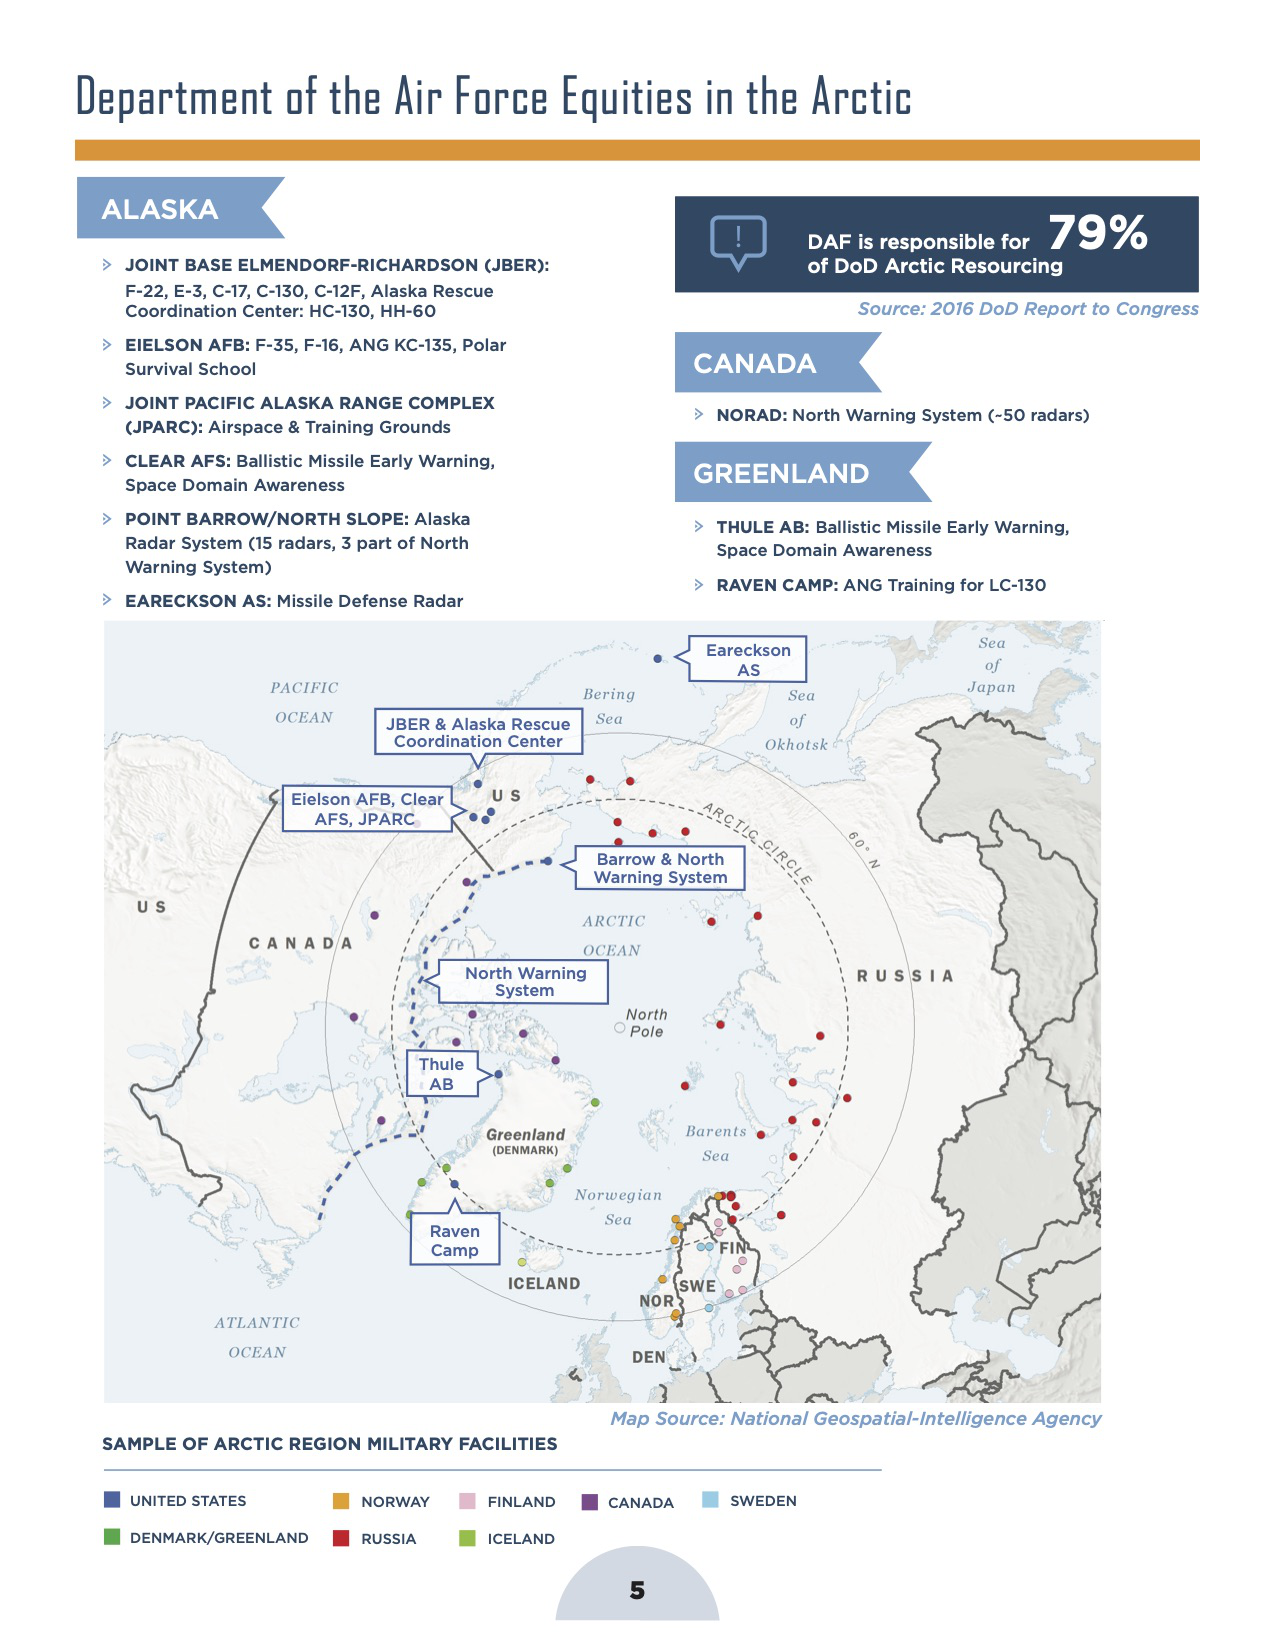

In [86]:
img = Image.open(BytesIO(requests.get(url).content))
img

In [92]:
layout = model.detect(imgdl)

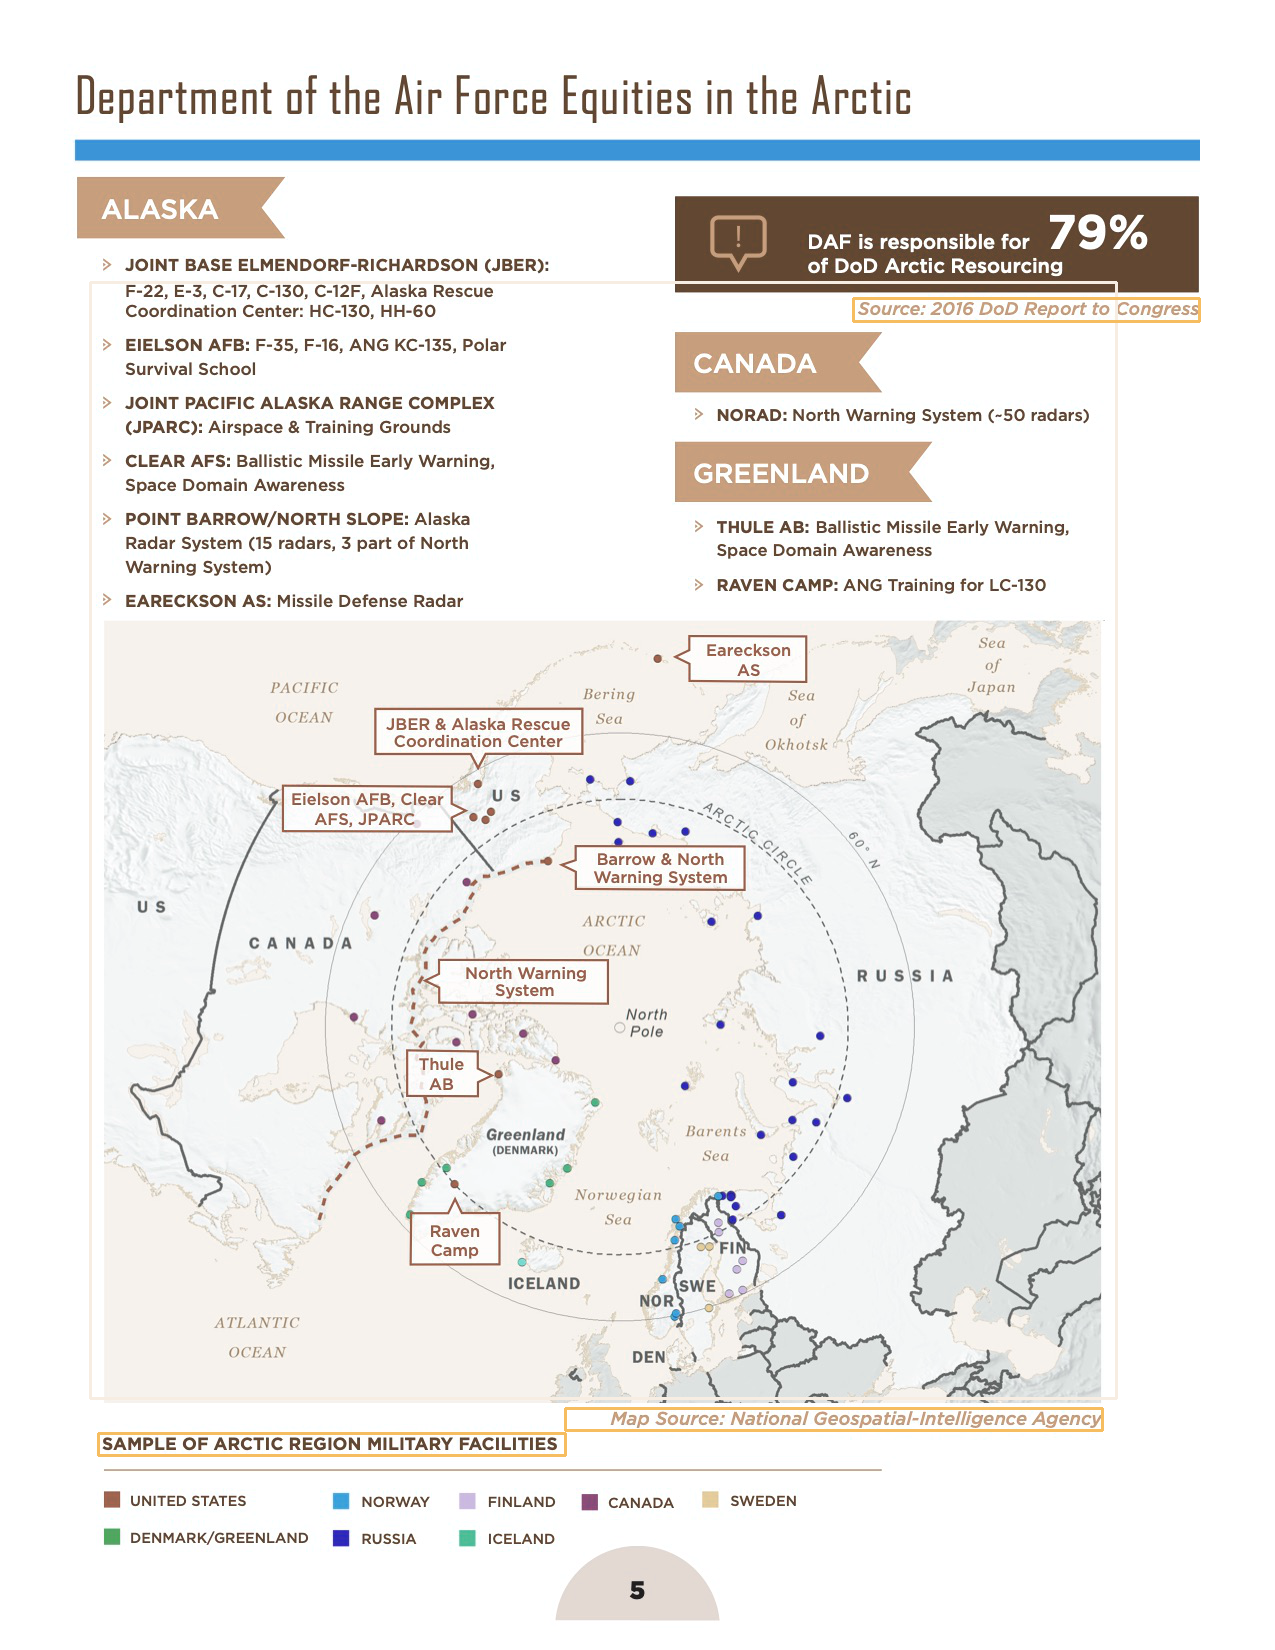

In [94]:
lp.draw_box(imgdl, layout, box_width=3)

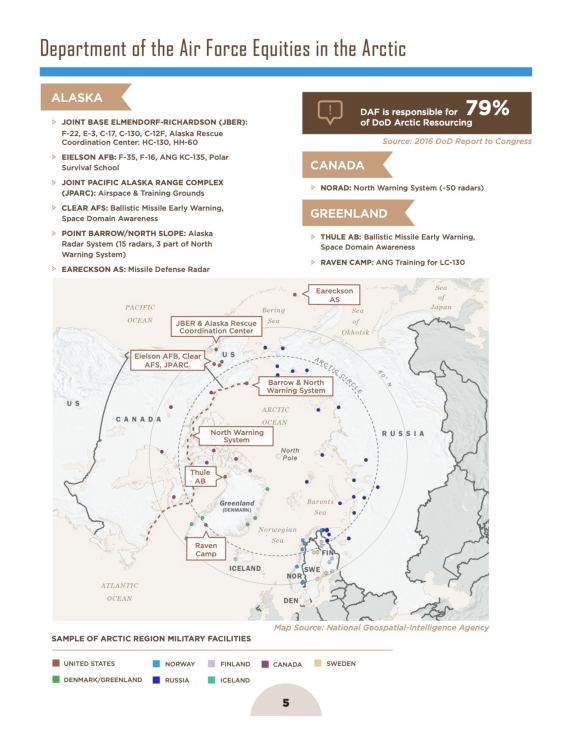

In [96]:
fig = plt.figure(figsize=(10,15))
plt.imshow(imgdl)
axis = plt.axis(False)

In [97]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=565.0419921875, y_1=1408.248046875, x_2=1102.0076904296875, y_2=1430.9903564453125), text=None, id=None, type=Text, parent=None, next=None, score=0.9632193446159363), TextBlock(block=Rectangle(x_1=98.54412078857422, y_1=1433.33935546875, x_2=565.6421508789062, y_2=1455.5933837890625), text=None, id=None, type=Text, parent=None, next=None, score=0.9490737915039062), TextBlock(block=Rectangle(x_1=853.138427734375, y_1=298.9957275390625, x_2=1199.797607421875, y_2=321.1148986816406), text=None, id=None, type=Text, parent=None, next=None, score=0.902302622795105)], page_data={})

In [98]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=565.0419921875, y_1=1408.248046875, x_2=1102.0076904296875, y_2=1430.9903564453125), text=None, id=None, type=Text, parent=None, next=None, score=0.9632193446159363), TextBlock(block=Rectangle(x_1=98.54412078857422, y_1=1433.33935546875, x_2=565.6421508789062, y_2=1455.5933837890625), text=None, id=None, type=Text, parent=None, next=None, score=0.9490737915039062), TextBlock(block=Rectangle(x_1=853.138427734375, y_1=298.9957275390625, x_2=1199.797607421875, y_2=321.1148986816406), text=None, id=None, type=Text, parent=None, next=None, score=0.902302622795105)], page_data={})

In [101]:
h, w = imgdl.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(imgdl)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

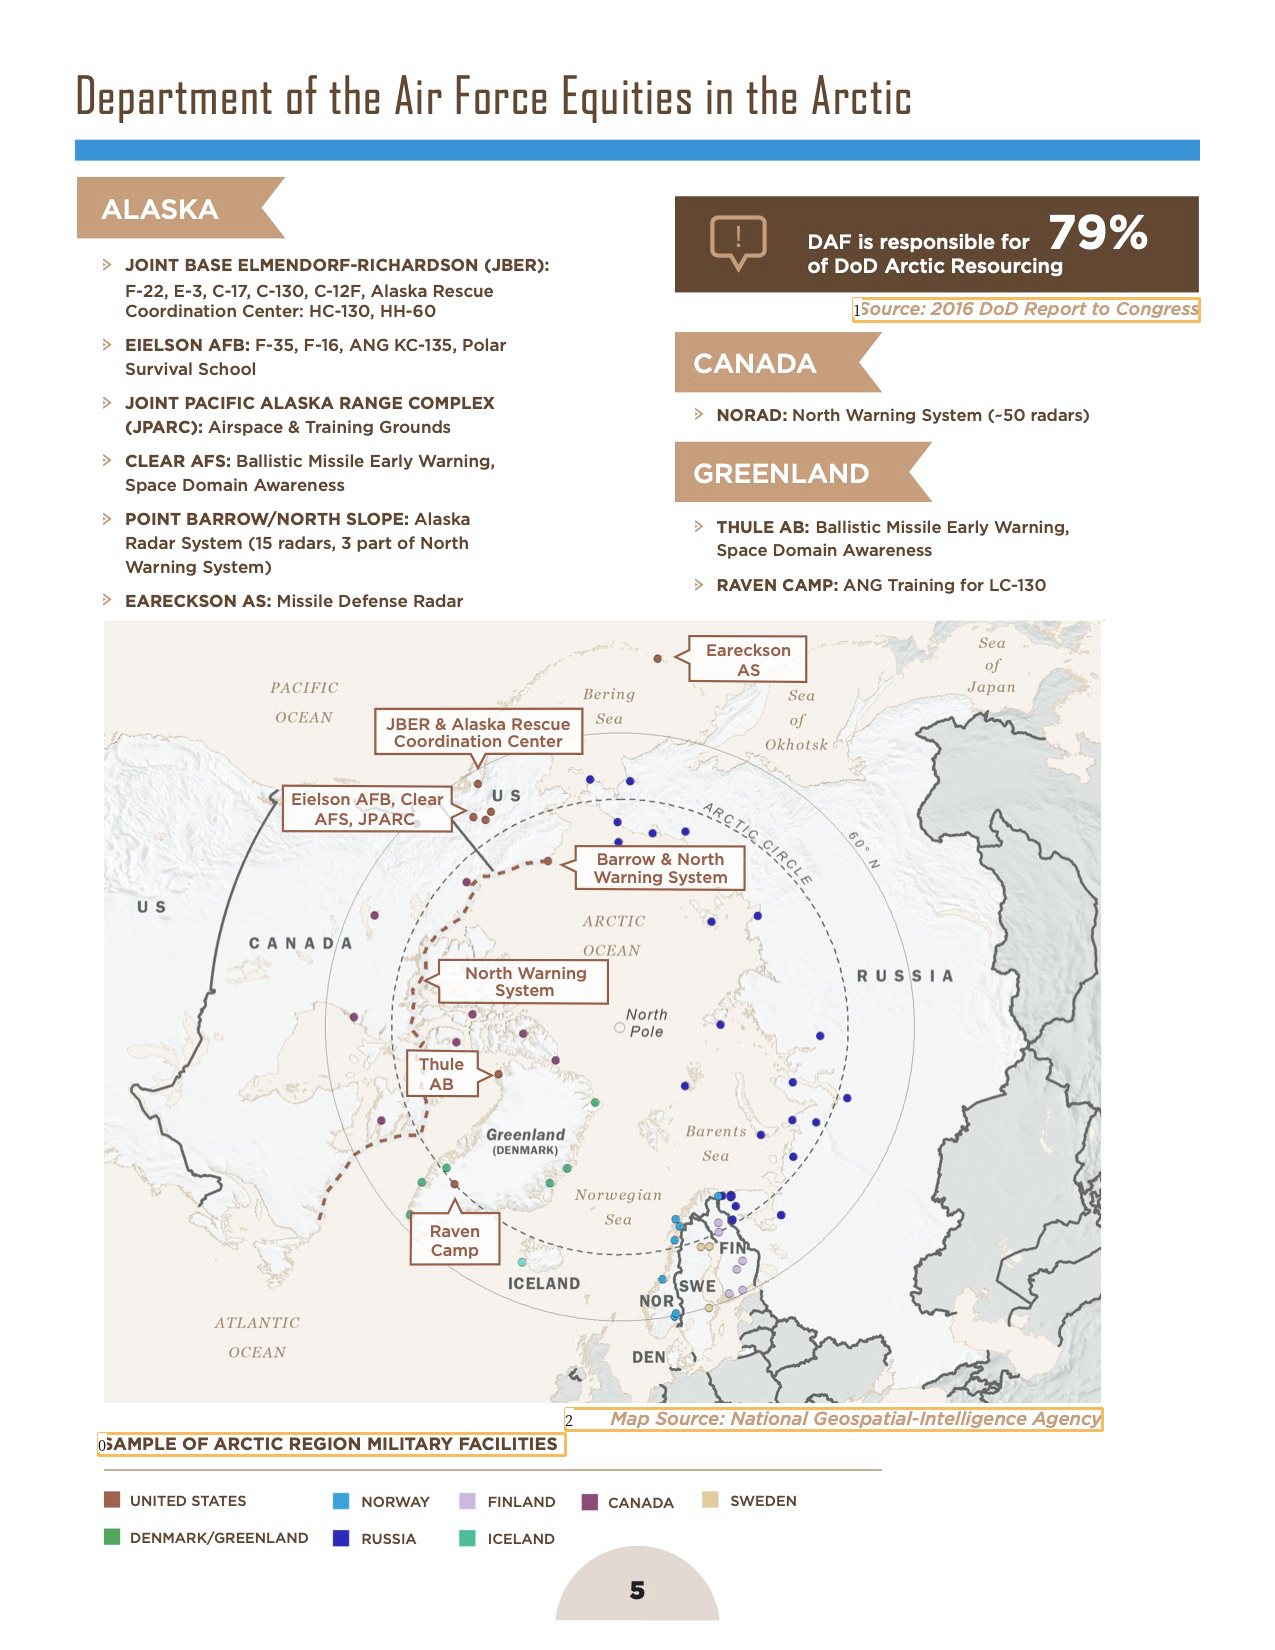

In [102]:
lp.draw_box(imgdl, text_blocks,
            box_width=3, 
            show_element_id=True)

In [103]:
ocr_agent = lp.TesseractAgent(languages='eng') 

In [105]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(imgdl))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [106]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

SAMPLE OF ARCTIC REGION MILITARY FACILITIES

---
Source: 2016 DoD Report to Congress

---
Map Source: National Geospatial-intelligence Agency

---
